# Predicting outcomes of running cases using decision trees
Decision trees are objects that contain the conditions leading to a particular outcome of business process.
In the following:
1. A representation of the log, on a given set of features, is obtained
2. A representation of the target classes is constructed
3. decision tree is calculated
4. decision tree is visualized


## Import required Python libraries
Before we start, first we need to import some programming libraries which we want to use.

In [1]:
import pm4py # Process Mining
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.filtering.log.end_activities import end_activities_filter
from pm4py.algo.filtering.log.start_activities import start_activities_filter

import numpy as np # Arrays
import pandas as pd # Data frames and data management

from sklearn import tree # Import Decision Tree Classifier
#from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

#from tabulate import tabulate

## Import event log and discover the process

We import an event log, stored in the IEEE XES format, from a given file path to the log variable.
The event log contains the process data that we need for our machine learning models.

In [2]:
# import XES file
variant = xes_importer.Variants.ITERPARSE
parameters = {variant.value.Parameters.TIMESTAMP_SORT: True}

log = xes_importer.apply('LoanApplicationTrimmed.xes', parameters=parameters)

parsing log, completed traces ::   0%|          | 0/20229 [00:00<?, ?it/s]

### Discover process as direct follows graph
A visualization of the suitable process model according (as a direct follows graph) to the event log imported before. The process model describes the order of events/activities that are executed during a process execution.

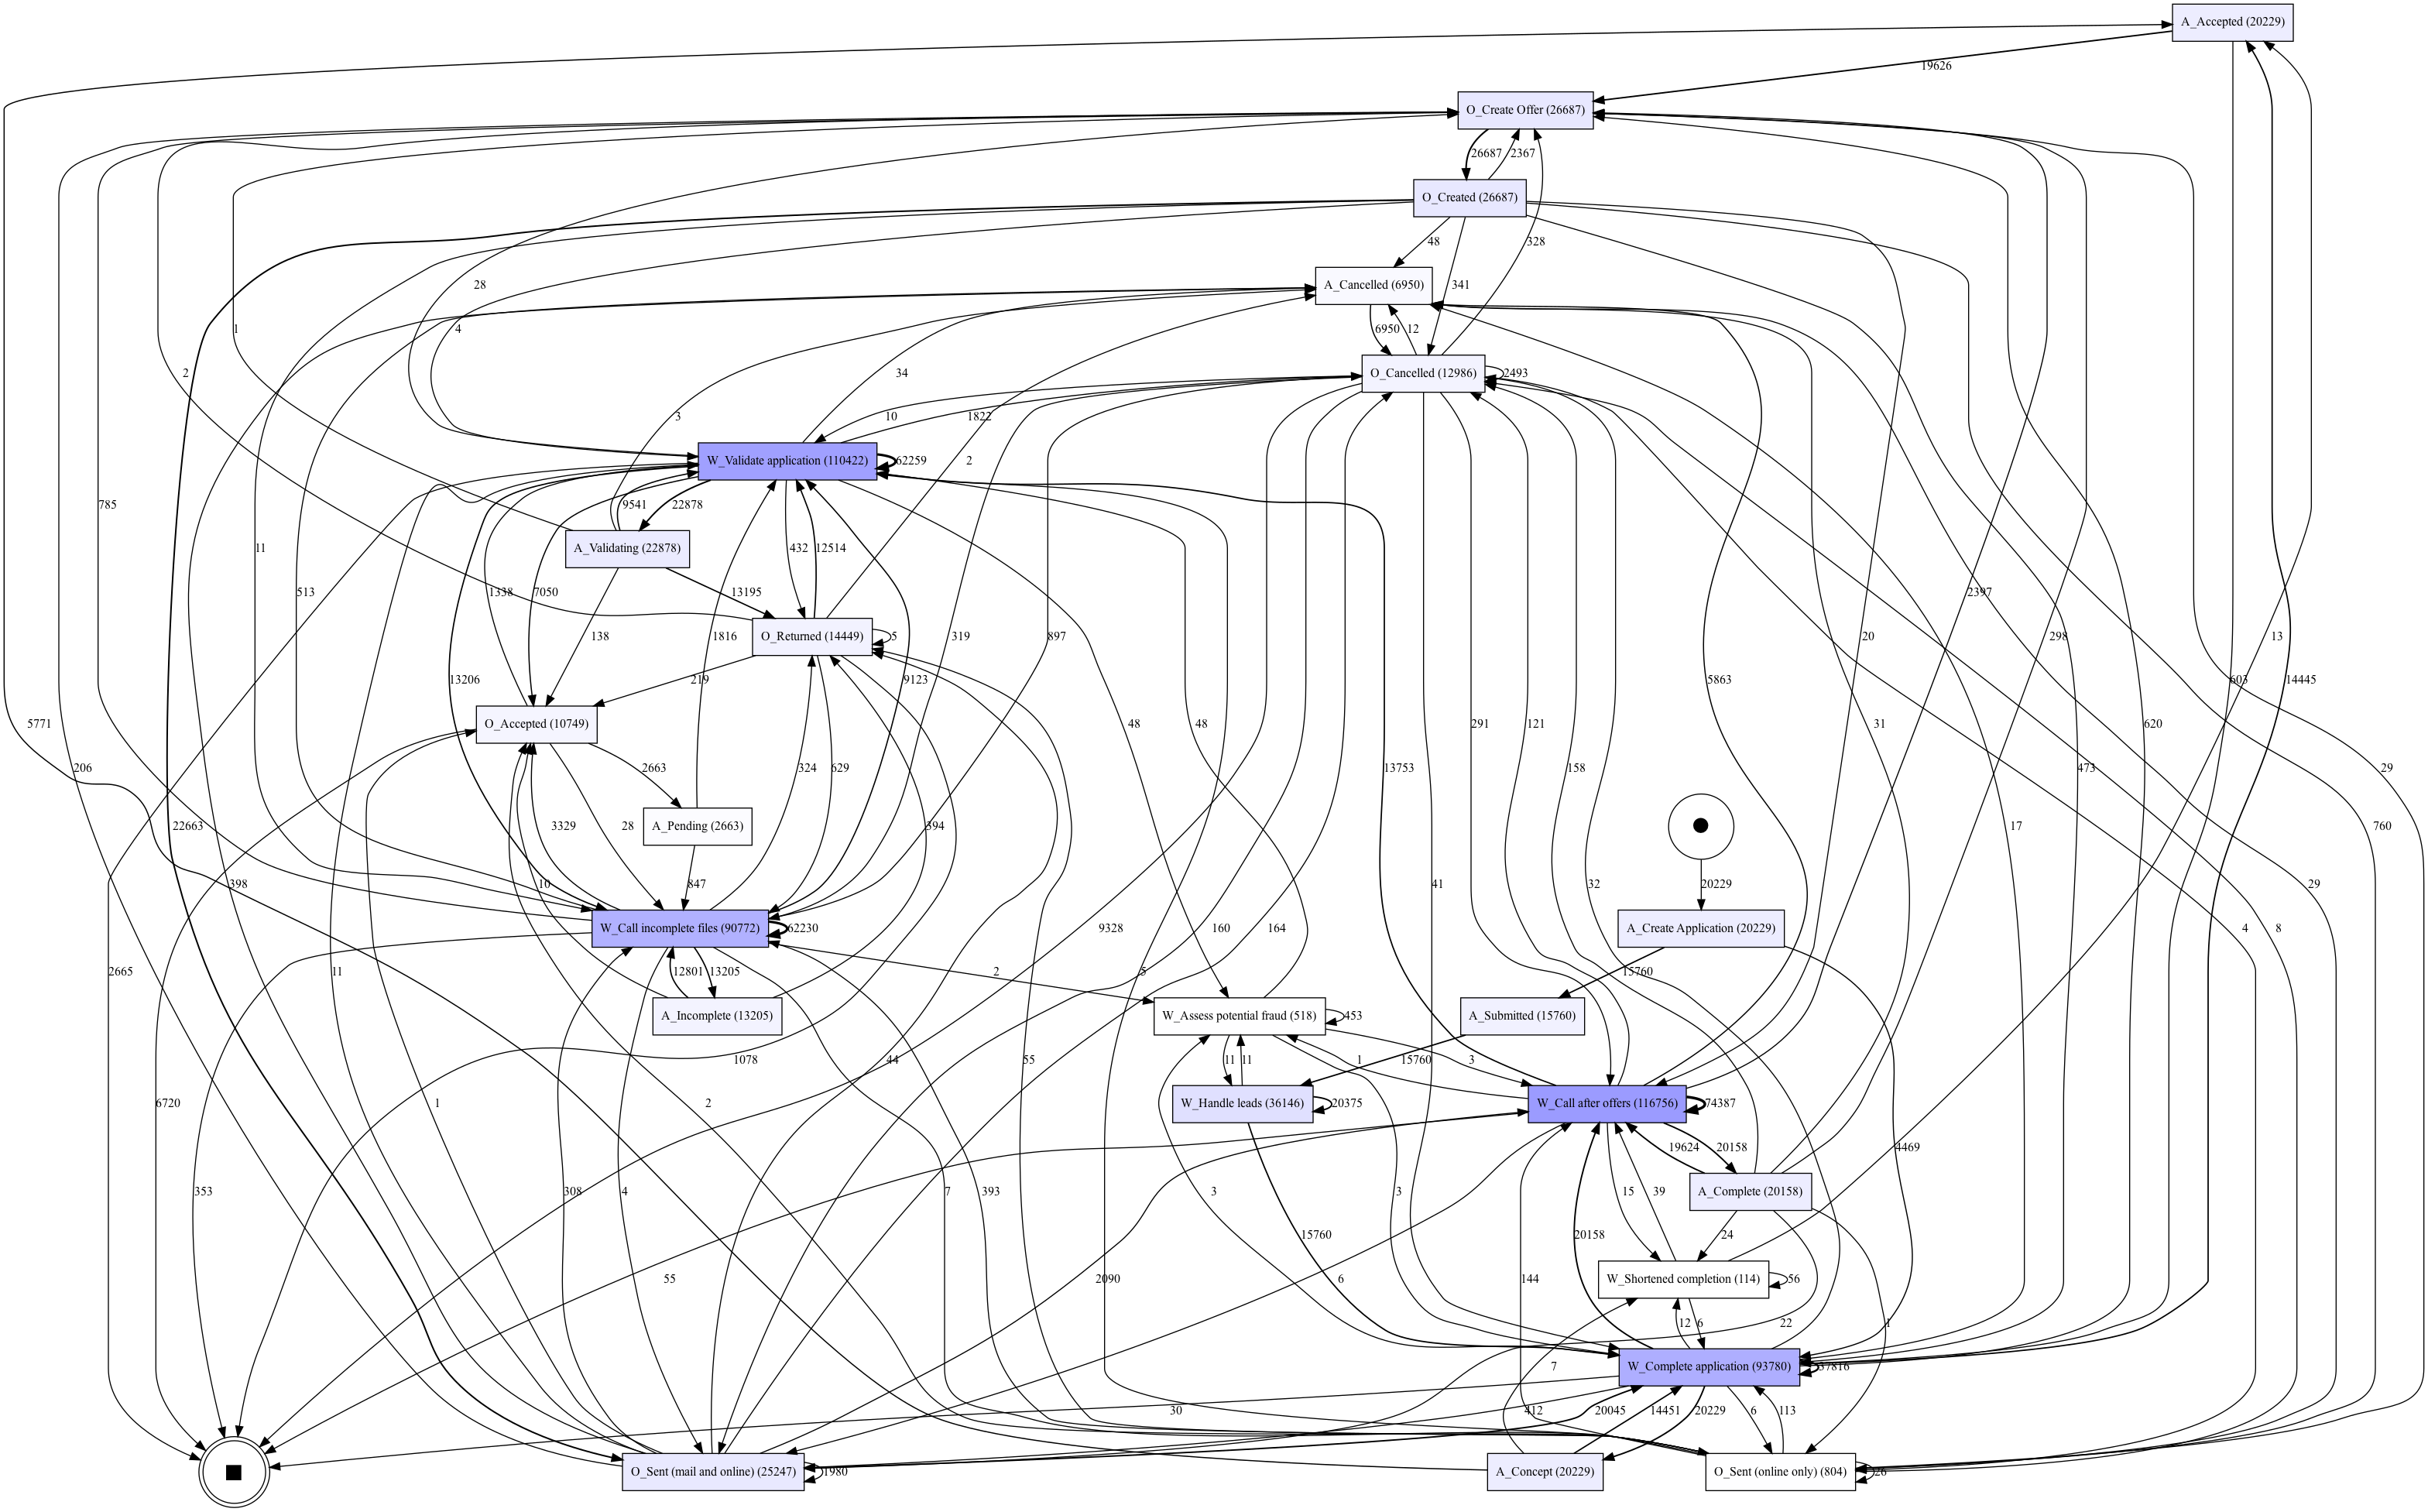

In [3]:
# Create direct follows graph (dfg)
dfg, start_activities, end_activities = pm4py.discover_dfg(log)
pm4py.view_dfg(dfg, start_activities, end_activities)

A loan application goes through a lifecycle consisting of the following states:
- Application Created: a new application has been created via the website.
- Submitted: a customer has submitted the application via the website. If the new application is created directly by the bank, this state is skipped.
- Concept: the application is in the concept state, that means that the customer just submitted it (or the bank started it), and a first assessment has been done automatically. An employee calls the customer to complete the application.
- Accepted: after the call with the customer, the application is completed and assessed again. If there is a possibility to make an offer, the state is accepted. The employee now creates one or more offers.
- Complete: the offers have been sent to the customer and the bank waits for the customer to return a signed offer along with the rest of the documents (payslip, ID etc)
- Validating: the offer and documents are received and checked.
- Incomplete: if documents are not correct or some documents are still missing, the application state is set to 'incomplete', which means the customers needs to send in further documents.
- Pending: if all documents are received and the assessment is positive, the loan is final and the customer is payed.
- Denied: if somewhere in the process the loan cannot be offered to the customer, because the application does not fit the acceptance criteria, the application is declined, which results in the state 'denied'.
- Cancelled: if the customer never sends in their documents or calls to tell they do not need the loan anymore, the application is cancelled.


### How to access and print traces and events of the log
Have a look on the data, i.e. attributes related to events and traces. These attributes are used for conditions in the decision trees.

In [4]:
#print(log[0]) #prints the first trace of the log
#print(log[0][0]) #prints the first event of the first trace

## Extract features and collect data from event log

First we filter our process data.
Event logs may have recordings of incomplete process executions. These incomplete traces are filtered out.
We just want to focus on traces with final process outcomes.
Relevant end activities are "O_Cancelled", "O_Returned", "O_Accepted"

In [5]:
# Filter the log for traces with end activities: "O_Cancelled", "O_Returned", "O_Accepted"
log_End = pm4py.filter_end_activities(log, ["O_Cancelled", "O_Returned", "O_Accepted"])

Compare the following process model (in the form of a direct follows graph) with the one above. We only have three end activities

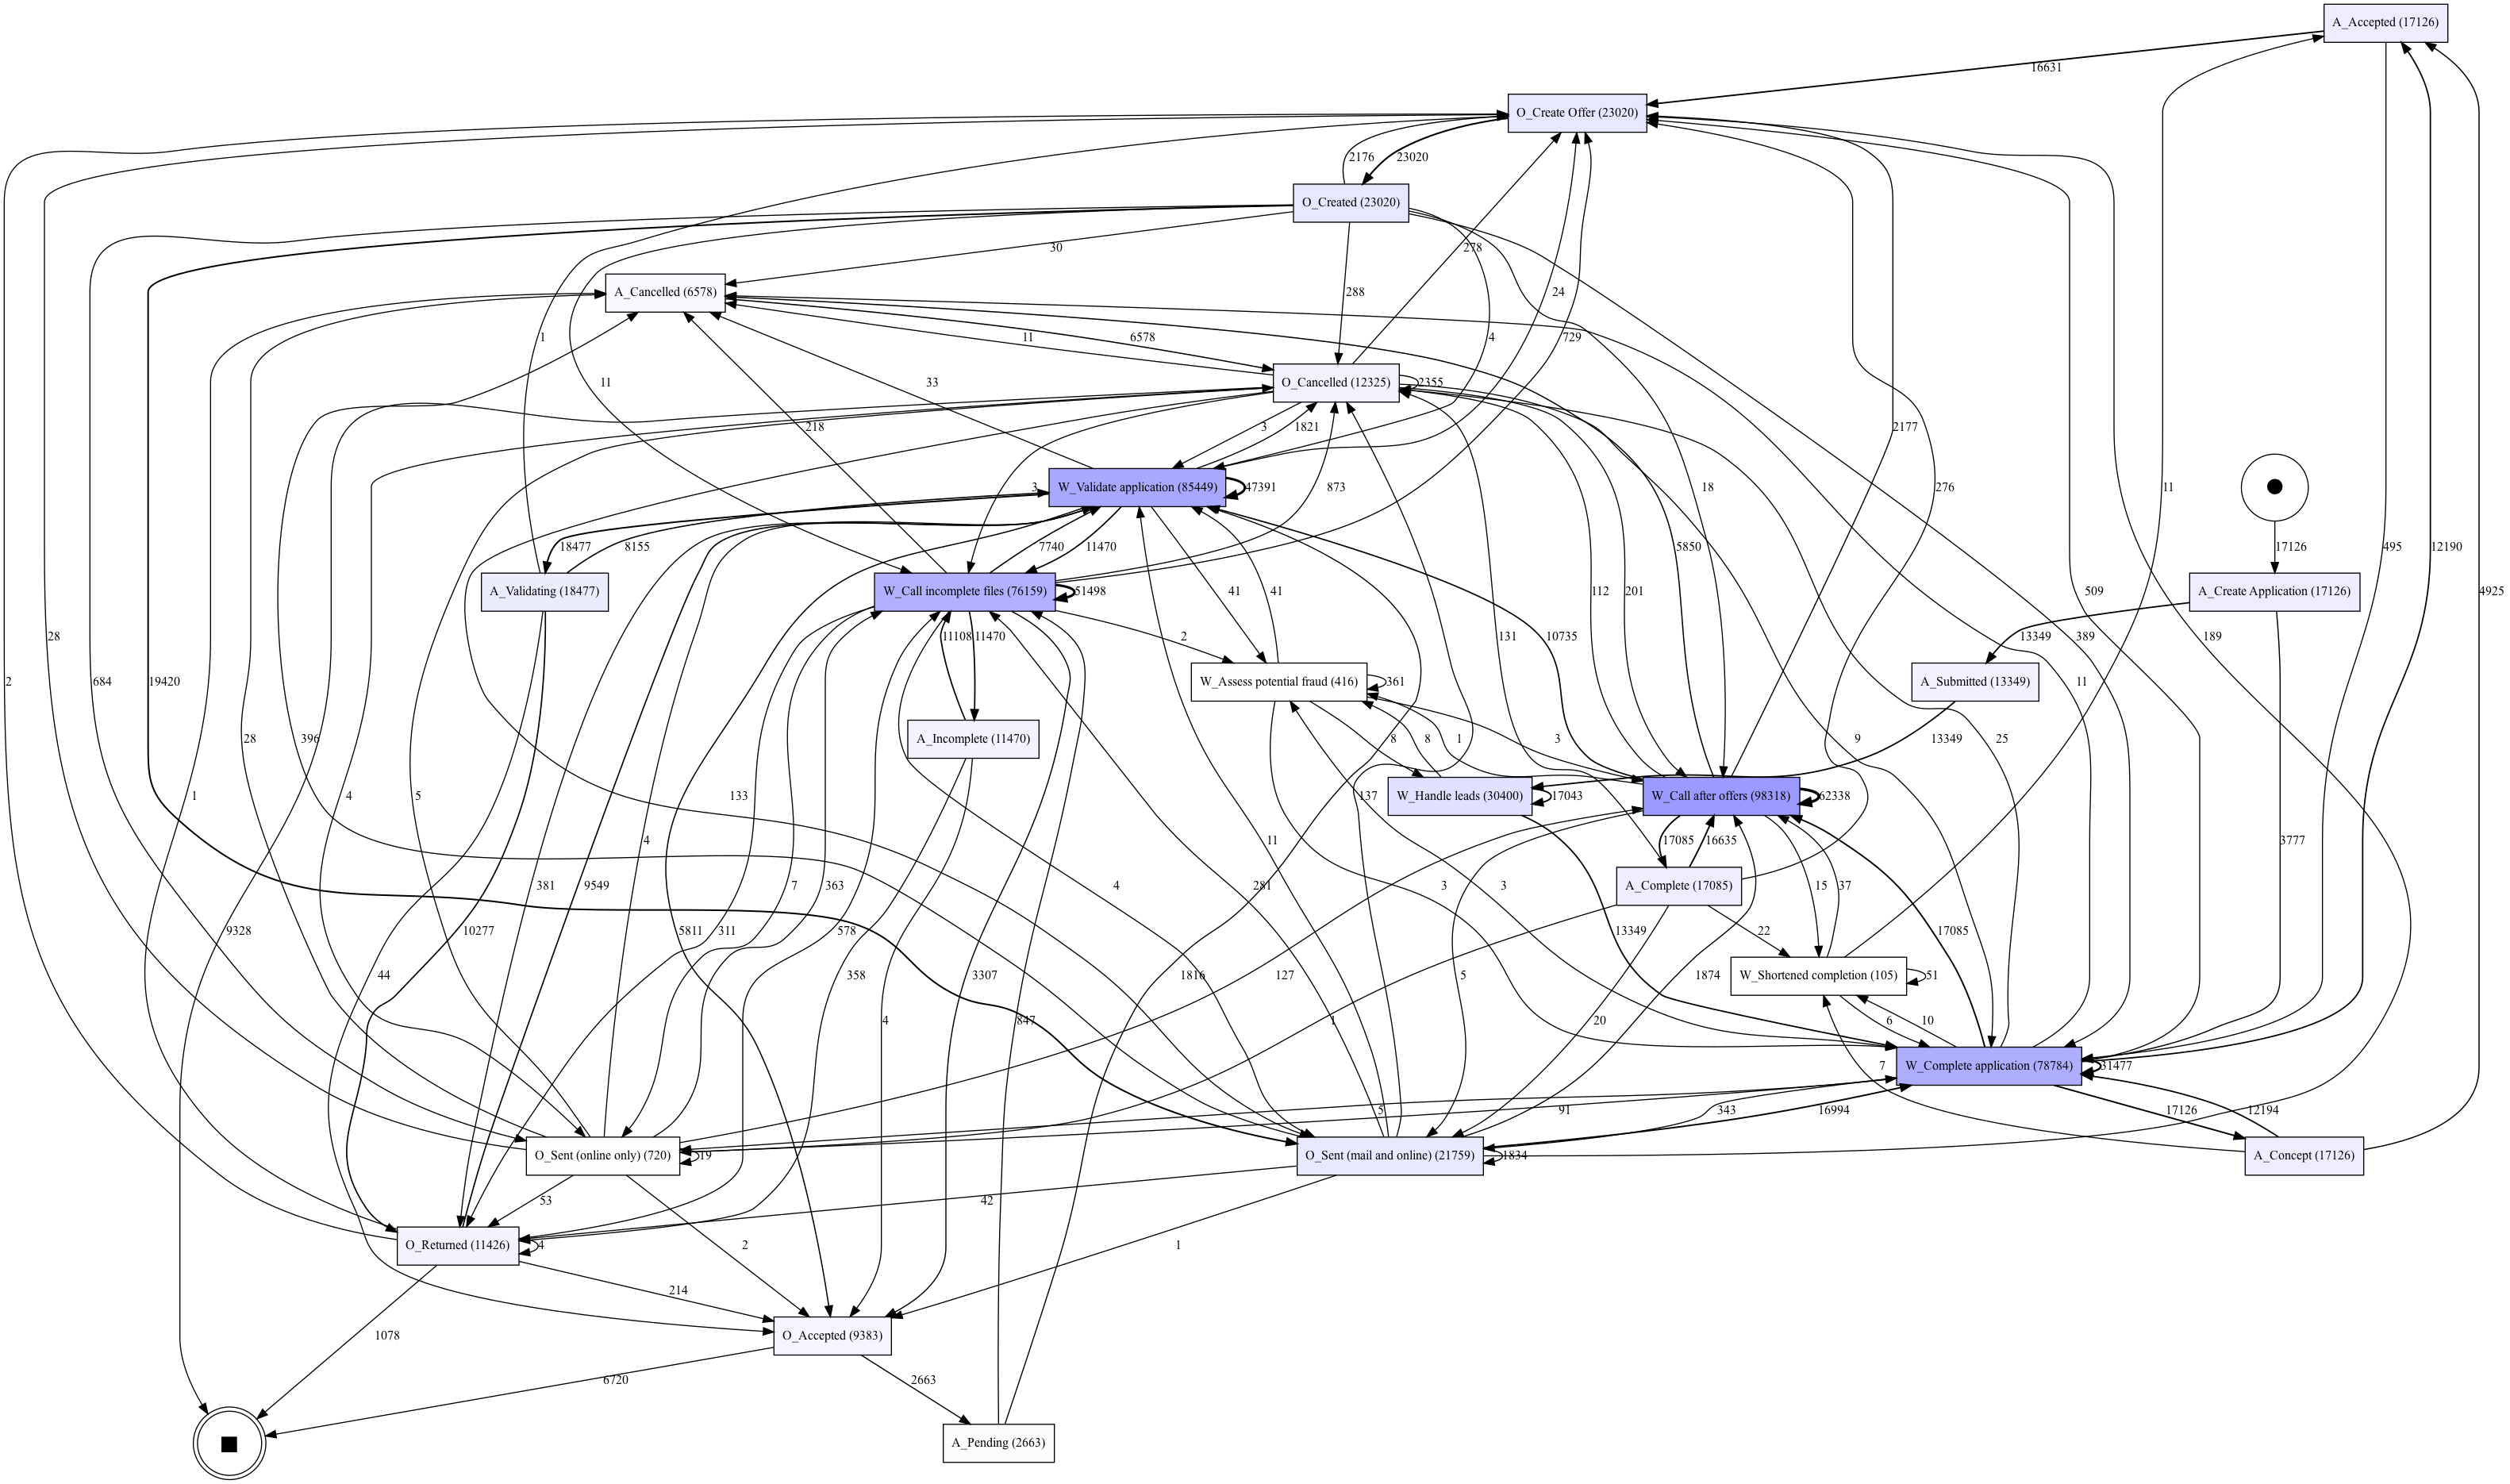

In [6]:
# Create direct follows graph (dfg)
dfg, start_activities, end_activities = pm4py.discover_dfg(log_End)
pm4py.view_dfg(dfg, start_activities, end_activities)

### Select descriptive features
Based on our log we select the set of descriptive features, i.e. the attributes of traces and events.

In [7]:
from pm4py.algo.transformation.log_to_features import algorithm as log_to_features

# manual representation of a log on a given set of features could be obtained.
data, feature_names = log_to_features.apply(log_End, parameters={"str_tr_attr": ["LoanGoal"], "str_ev_attr": ["concept:name"], "num_tr_attr": ["RequestedAmount"], "num_ev_attr": []})
print("Selected features: ", feature_names)

Selected features:  ['trace:LoanGoal@Boat', 'trace:LoanGoal@Business goal', 'trace:LoanGoal@Car', 'trace:LoanGoal@Caravan / Camper', 'trace:LoanGoal@Debt restructuring', 'trace:LoanGoal@Existing loan takeover', 'trace:LoanGoal@Extra spending limit', 'trace:LoanGoal@Home improvement', 'trace:LoanGoal@Motorcycle', 'trace:LoanGoal@Remaining debt home', 'trace:LoanGoal@Tax payments', 'event:concept:name@A_Accepted', 'event:concept:name@A_Cancelled', 'event:concept:name@A_Complete', 'event:concept:name@A_Concept', 'event:concept:name@A_Create Application', 'event:concept:name@A_Incomplete', 'event:concept:name@A_Pending', 'event:concept:name@A_Submitted', 'event:concept:name@A_Validating', 'event:concept:name@O_Accepted', 'event:concept:name@O_Cancelled', 'event:concept:name@O_Create Offer', 'event:concept:name@O_Created', 'event:concept:name@O_Returned', 'event:concept:name@O_Sent (mail and online)', 'event:concept:name@O_Sent (online only)', 'event:concept:name@W_Assess potential fraud', 

Transfer the features into a Pandas dataframe that is used to train the decision tree.

In [8]:
dataframe = pd.DataFrame(data, columns=feature_names)
dataframe.head()

,trace:LoanGoal@Boat,trace:LoanGoal@Business goal,trace:LoanGoal@Car,trace:LoanGoal@Caravan / Camper,trace:LoanGoal@Debt restructuring,trace:LoanGoal@Existing loan takeover,trace:LoanGoal@Extra spending limit,trace:LoanGoal@Home improvement,trace:LoanGoal@Motorcycle,trace:LoanGoal@Remaining debt home,...,event:concept:name@O_Sent (mail and online),event:concept:name@O_Sent (online only),event:concept:name@W_Assess potential fraud,event:concept:name@W_Call after offers,event:concept:name@W_Call incomplete files,event:concept:name@W_Complete application,event:concept:name@W_Handle leads,event:concept:name@W_Shortened completion,event:concept:name@W_Validate application,trace:RequestedAmount
0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,1,1,1,1,0,1,20000.0
1,0,0,0,0,0,0,0,1,0,0,...,1,0,0,1,1,1,1,0,1,15000.0
2,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,1,1,1,0,1,5000.0
3,0,0,0,0,0,0,0,1,0,0,...,1,0,0,1,0,1,1,0,0,35000.0
4,0,0,0,0,0,1,0,0,0,0,...,1,0,0,1,0,1,1,0,0,13000.0


### Select the target feature
The target classes are formed. Each endpoint of the process belongs to a different class.

In [9]:
from pm4py.objects.log.util import get_class_representation

# select the target features
target, classes = get_class_representation.get_class_representation_by_str_ev_attr_value_value(log_End, "concept:name")
print("Classes: ", classes)

Classes:  ['O_Accepted', 'O_Cancelled', 'O_Returned']


## Create decision tree
The decision tree is now calculated and visualized. A parameter is the performance `criterion` and the `max_depth`of the tree.
Input for descriptive features is the data frame (with selected columns) and the target feature.

In [10]:
clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=2)

clf.fit(dataframe[["event:concept:name@W_Call incomplete files","trace:RequestedAmount"]], target)
feature_names = ["event:concept:name@W_Call incomplete files","trace:RequestedAmount"]


from pm4py.visualization.decisiontree import visualizer as dectree_visualizer
gviz = dectree_visualizer.apply(clf, feature_names, classes)

The decision tree is visualized.

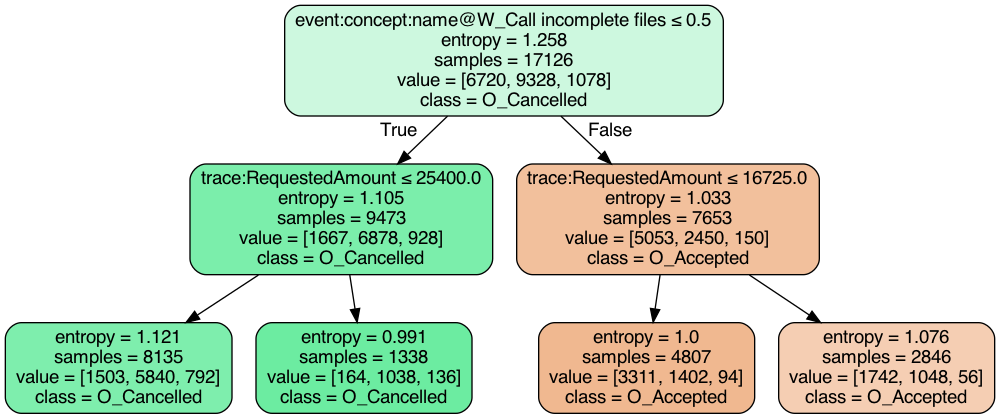

In [11]:
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_names,class_names=classes)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

## Predict the process outcome
Create the prediction using the classifier.
The following function requests as attributes the information, if there was a call in a (maybe incomplete) case and the request amount of the credit. In addition it requires the decision tree as classifier in order to make predictions.

In [12]:
### Function for Predict the response for test dataset
def predictOffer(callforincompletefiles, requestedAmount, clf):
    if callforincompletefiles == "yes":
        call = 1
    if callforincompletefiles == "no":
        call = 0    
    x_test=[[call, requestedAmount]]
    y_pred = clf.predict(x_test)
    print("Predition: The offer might be",classes[y_pred[0]])

Make a prediction, for example for "yes, there is a call for incomplete files" (`call = "yes"`) and the requested amount of 10000 (`requestedAmount = 10000`).

In [13]:
callforincompletefiles = str(input('Are there calls for incomplete files? '))
requestedAmount = int(input('What is the requested amount? '))
predictOffer(callforincompletefiles, requestedAmount, clf)

Are there calls for incomplete files? yes
What is the requested amount? 20000
Predition: The offer might be O_Accepted
